In [99]:
%load_ext autoreload
%autoreload 2
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import pandas as pd
import numpy as np

## Load Data

In [26]:
data = pd.read_csv("data/example_guide_data.tsv", sep="\t")

In [27]:
data

,gene_name,spacer_id,spacer_seq,norm_count_plasmid,norm_count_D7_Rep1,norm_count_D7_Rep2,norm_count_D14_Rep1,norm_count_D14_Rep2,norm_count_PLX7_Rep1,norm_count_PLX7_Rep2,norm_count_PLX14_Rep1,norm_count_PLX14_Rep2
0,A1BG,s_1,ACCTGTAGTTGCCGGCGTGC,10.366767,8.142715,10.177020,7.986137,6.461769,12.260794,9.095489,4.285777,2.816931
1,A1BG,s_2,GTCGCTGAGCTCCGATTCGA,8.805639,9.941240,8.059246,8.605162,6.461769,7.491095,10.515751,4.168428,5.239506
2,A1CF,s_3,AAGTTGCTTGATTGCATTCT,19.493360,26.025195,25.203128,33.277722,21.514938,19.253963,27.913951,9.801189,9.327602
3,A1CF,s_4,ACTTCCCCGAGACCTTTTTG,20.454054,23.147554,23.387894,28.856116,20.649048,20.688459,21.167710,7.219507,8.822898
4,A1CF,s_5,AGTGCCGCTCAATCCATCCC,40.868803,54.801599,54.952807,56.270072,53.353057,51.996336,47.868622,12.206848,13.768989
...,...,...,...,...,...,...,...,...,...,...,...,...
64071,ZZZ3,s_65010,GACCAATATACCCATAGCCT,9.526160,3.209617,5.638933,2.326482,7.793908,4.084167,3.414444,1.176024,1.757055
64072,ZZZ3,s_65011,GTTCTTCAACAGTCCACAAC,15.410411,5.316461,6.697820,4.802581,6.661590,8.710417,7.888267,2.760238,1.857995
64073,ZZZ3,s_65012,TATTGGTCCCATACGATCTC,26.218219,22.428144,24.850166,23.373325,28.242239,20.903633,26.422677,7.688904,9.125720
64074,ZZZ3,s_65013,TCTTATGTGCAGATGATAAG,9.165899,3.363776,3.974968,2.768642,1.199821,6.271773,3.982549,1.469397,2.059877


## How many genes are screened?

In [28]:
genes = set(data.gene_name)
len(genes)

17419

In [29]:
'BRAF' in genes

True

## sgRNA Position Weight Matrix

In [46]:
import Bio

In [47]:
guides = [Bio.Seq.Seq(spacer) for spacer in data.spacer_seq]

AttributeError: module 'Bio' has no attribute 'Seq'

In [37]:
counts = np.array([(seqs == 'A').sum(axis=0), (seqs == 'G').sum(axis=0), (seqs == 'C').sum(axis=0), (seqs == 'T').sum(axis=0)]).astype(float)

In [41]:
len(counts[0])

20

## Compute GC Content

In [56]:
gc_content = np.array([compute_gc_content(seq) for seq in data.spacer_seq])

In [57]:
np.mean(gc_content)

0.5204397902490792

In [58]:
np.std(gc_content)


0.12213474389481595

In [59]:
hist(gc_content)

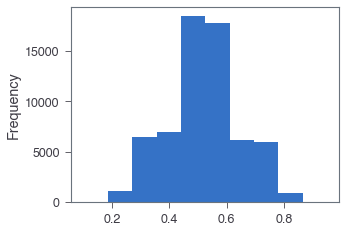

In [60]:
pd.Series(gc_content).plot.hist()

## Detect Hairpins

In [64]:
hairpins = [detect_palindrome(seq) for seq in data.spacer_seq]

In [65]:
sum(hairpins)

0

## Compute Molecular Weights of Guides

In [97]:
mol_weights = [compute_weight(seq) for seq in data.spacer_seq]

ImportError: cannot import name 'BiopythonWarning' from 'Bio' (/Users/remy/.pyenv/versions/3.7.3/lib/python3.7/site-packages/Bio/__init__.py)

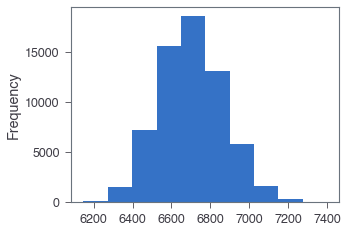

In [90]:
pd.Series(mol_weights).plot.hist()

In [91]:
pd.Series(mol_weights).describe()

count    64076.000000
mean      6699.195206
std        166.337061
min       6148.000000
25%       6575.000000
50%       6694.000000
75%       6812.000000
max       7399.000000
dtype: float64

## Calculate Entropies of the gRNAs

In [85]:
shannon = [compute_entropy(seq) for seq in data.spacer_seq]

In [86]:
pd.Series(shannon).describe()

count    64076.000000
mean         0.934754
std          0.051567
min          0.570577
25%          0.907490
50%          0.947731
75%          0.970323
max          1.000000
dtype: float64

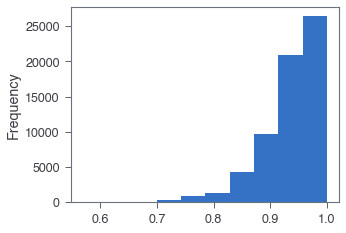

In [87]:
pd.Series(shannon).plot.hist()

## How many Spacers contain a Start Codon?

In [98]:
sum([detect_start(seq) for seq in data.spacer_seq])

16919

## Compute Activities

In [100]:
data.columns

Index(['gene_name', 'spacer_id', 'spacer_seq', 'norm_count_plasmid',
       'norm_count_D7_Rep1', 'norm_count_D7_Rep2', 'norm_count_D14_Rep1',
       'norm_count_D14_Rep2', 'norm_count_PLX7_Rep1', 'norm_count_PLX7_Rep2',
       'norm_count_PLX14_Rep1', 'norm_count_PLX14_Rep2'],
      dtype='object')

In [112]:
activities = [compute_fold_change(t1, t2) for t1, t2 in [*zip(data["norm_count_plasmid"], data[['norm_count_D14_Rep1', 'norm_count_D14_Rep2']].mean(axis=1))]]

In [113]:
activities

[0.521105581748411,
 0.22511402035141914,
 -0.49099984429951155,
 -0.2751921931035561,
 -0.42348033014217756,
 0.08326277461197489,
 -0.06423928664019764,
 0.6003884226641802,
 -0.3495232831238579,
 -1.0010272476327517,
 0.19056011156324554,
 0.24478401191834073,
 -0.5193854398301897,
 -0.6796147043908243,
 -0.46468214490492116,
 -0.5925898255066968,
 -0.05301255341772761,
 -0.5815107855337813,
 0.16198773103867803,
 -0.40280248080555797,
 0.43075643763663485,
 0.8177379272265568,
 0.6135867863719702,
 -0.38652374254385174,
 -0.15597964963724065,
 0.8597993650475357,
 -0.9633500879462605,
 0.0949794940919595,
 0.677771737062505,
 0.24211519674403542,
 -1.433706280796727,
 -0.03490911219565482,
 -0.7312100740913188,
 0.24524089932351567,
 0.3391850205859022,
 -0.3938243147697661,
 0.766992880449636,
 -0.1979038134902188,
 -0.6203101570254558,
 0.1891685876201062,
 0.07605957446866349,
 -0.32888932554112643,
 0.12974378576115128,
 0.23791592395172065,
 -0.3164354904993964,
 -0.4177595321